# 라이브러리

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Okt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings(action='ignore')
from wordcloud import WordCloud
from collections import Counter
from wordcloud import ImageColorGenerator
from PIL import Image

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 20

# 사용자 정의함수

In [78]:
# 특수문자와 영어 & 조사, 복수관사 제거
okt = Okt()

def prepro_text(text):
    
    text = re.sub(r'[^가-힣0-9]', ' ', str(text))

    prepro_words = []
    for word, tag in okt.pos(text):
        if tag not in ['Josa', 'Suffix']:
            prepro_words.append(word)

    result = ' '.join(prepro_words)

    return result 

# 데이터 로드

In [3]:
df = pd.read_csv('./1-8월 뉴스.csv', encoding='utf-8-sig')
df.head()

,title,text,url,media,date
0,무너지는 일과 삶의 경계···노동이 녹아내린다,이 땅에서 ‘비정규직’이라는 표현이 광범위하게 쓰인 지 20여년. 정부가 신규 일자...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
1,일자리 아닌 일거리···'일정치 않음'을 살다 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\n노동의 미래를 모두 알 수는 없다. 다만 현실에서 일어나...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
2,이곳은…기계의 정확도 높이는 ‘인간부품’ 육성공장 아닐까 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\nㆍAI 학습데이터 가공 기업 ‘크라우드웍스’ 교육장 참관...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
3,"지혜씨, 지훈씨를 부탁해! [인포그래픽]",새로 태어나는 아이들은 줄어들고 어르신들은 계속 나이를 먹어 갑니다. 2020년 새...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
4,"[20대 리포트] “20대, 함부로 판단말라… 내 길 내가 간다”",새천년의 시작과 함께 세상에 나온 2000년대생들이 어느덧 사회 변화를 이끌 20대...,https://news.naver.com/main/read.nhn?mode=LPOD...,국민일보,2020-01-01


In [5]:
df.tail()

,title,text,url,media,date
29036,"""2.5단계로 무급휴가 요구""… 코로나 재유행에 살아난 '갑질'",직장인 A씨는 수도권 사회적 거리두기 2.5단계를 시행하는 30일부터 다음달 6일...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29037,모호한 조치ㆍ 깜깜이 환자 비율 40%육박... 거리두기 2.5단계 효과 있을까,"30일 0시부터 서울 전역에 강화된 사회적 거리두기(2.5단계)가 시행됐지만, 전문...",https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29038,내일부터 서울 시내버스 밤 9시 이후 20% 감축… 주말 수준으로,수도권의 ‘사회적 거리두기’ 2.5단계 시행 기간에 맞춰 서울 시내버스의 야간 운행...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29039,집단휴업 두고 전공의 vs 정부 '강대강 대치'... 의료공백 장기화 불가피,21일부터 10일째 무기한 집단휴진을 이어가고 있는 전공의(인턴ㆍ레지던트)들과 정부...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29040,"""제자 한명이라도 피해 입으면 집단휴진"" 의대 교수까지 화났다",전공의들의 집단휴업을 둘러싼 의ㆍ정 갈등이 고조되는 가운데 의료현장을 책임지는 의대...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31


# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29041 entries, 0 to 29040
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   29041 non-null  object
 1   text    29041 non-null  object
 2   url     29041 non-null  object
 3   media   29041 non-null  object
 4   date    29041 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [9]:
# 언론사별 분포
df['media'].value_counts()

경향신문    3715
세계일보    3636
조선일보    3435
동아일보    3316
한국일보    3073
문화일보    2891
서울신문    2817
국민일보    2320
한겨레     2276
중앙일보    1562
Name: media, dtype: int64

In [48]:
media_df = pd.DataFrame(
    columns=['media', 'count'],
    )
media_df['media'] = df['media'].value_counts().index
media_df['count'] = df['media'].value_counts().values
media_df

,media,count
0,경향신문,3715
1,세계일보,3636
2,조선일보,3435
3,동아일보,3316
4,한국일보,3073
5,문화일보,2891
6,서울신문,2817
7,국민일보,2320
8,한겨레,2276
9,중앙일보,1562


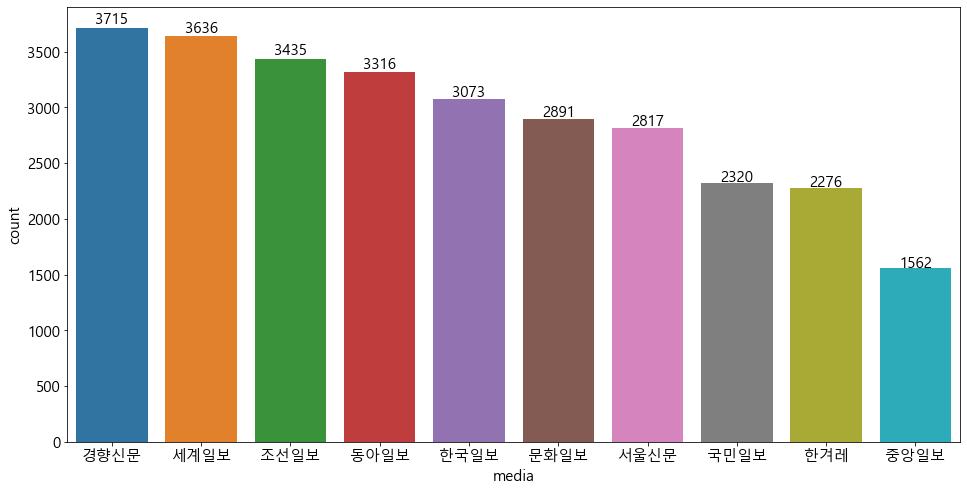

In [55]:
plt.figure(figsize=(16,8))
bar_graph = sns.barplot(data=media_df, x='media', y='count')
ax = bar_graph

for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width()/2, p.get_height()*1.02),
                ha='center',
                va='center',
                fontsize=15)

plt.xticks(fontsize=15)
plt.show()

C:\Users\USER\.conda\envs\data_env_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


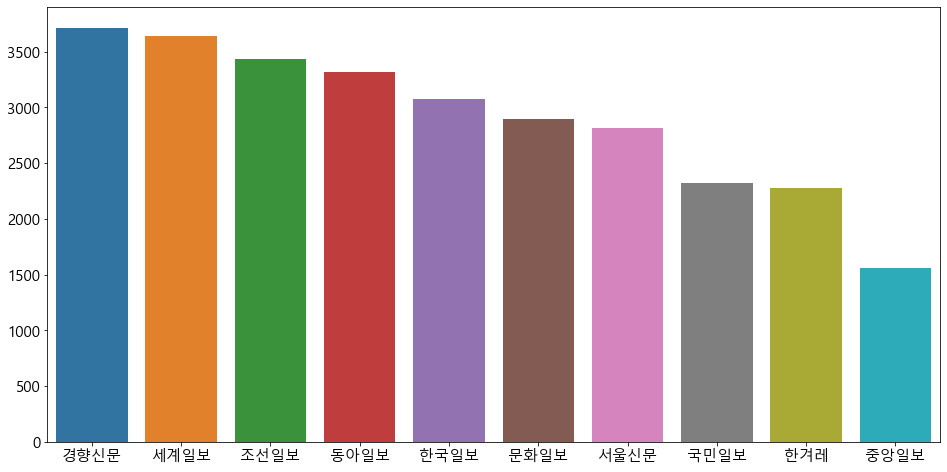

In [43]:
# 언론사별 기사 개수 
plt.figure(figsize=(16,8))
sns.barplot(df['media'].value_counts().index, df['media'].value_counts().values)
plt.rc('font', size=15)
plt.show()

In [17]:
# 글자수 
df['title_len'] = [len(prepro_title) for prepro_title in [title.replace(' ', '') for title in  df['title']]]
df['text_len'] = [len(prepro_title) for prepro_title in [title.replace(' ', '') for title in  df['text']]]

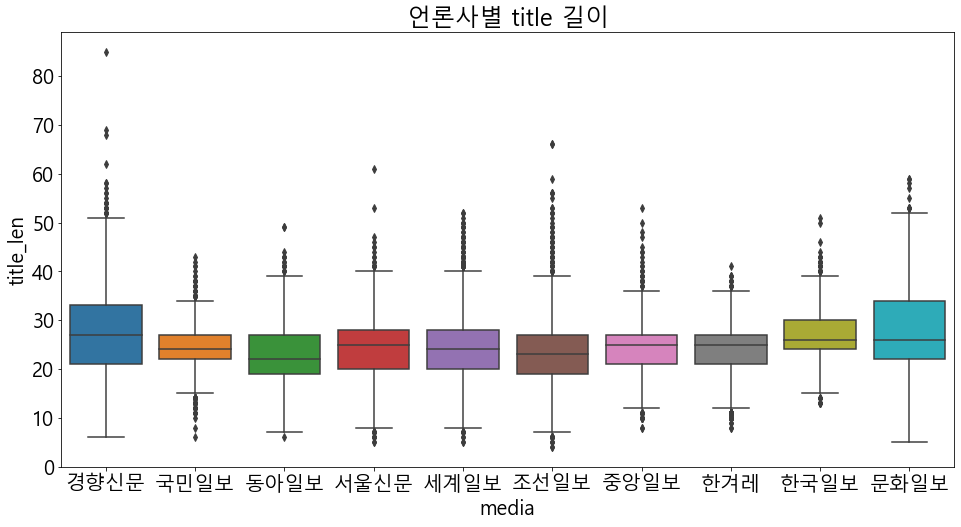

In [28]:
# 언론사별 title, text 글자 수 확인

plt.figure(figsize=(16,8))
plt.title('언론사별 title 길이')
sns.boxplot(
    x=df['media'],
    y=df['title_len'],
    data=df)
plt.show()

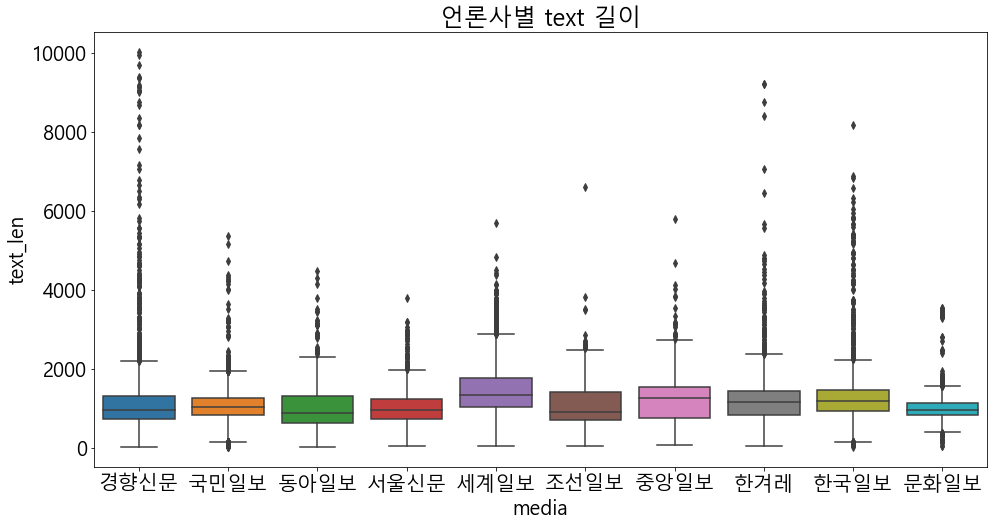

In [29]:
plt.figure(figsize=(16,8))
plt.title('언론사별 text 길이')
sns.boxplot(
    x=df['media'],
    y=df['text_len'],
    data=df)
plt.show()

In [37]:
# 각 언론사별 title, text 길이 평균값
for media in df['media'].value_counts().index:
    title_mean = df['title_len'][df['media']==media].describe()['mean']
    text_mean = df['text_len'][df['media']==media].describe()['mean']

    print(f'{media} title 평균 : {round(title_mean,2)}')
    print(f'{media} text 평균 : {round(text_mean,2)}')
    print()

경향신문 title 평균 : 27.51
경향신문 text 평균 : 1114.28

세계일보 title 평균 : 24.79
세계일보 text 평균 : 1467.3

조선일보 title 평균 : 23.55
조선일보 text 평균 : 1026.8

동아일보 title 평균 : 22.92
동아일보 text 평균 : 985.63

한국일보 title 평균 : 26.69
한국일보 text 평균 : 1284.69

문화일보 title 평균 : 27.96
문화일보 text 평균 : 1024.61

서울신문 title 평균 : 24.03
서울신문 text 평균 : 1008.3

국민일보 title 평균 : 24.11
국민일보 text 평균 : 1037.26

한겨레 title 평균 : 23.8
한겨레 text 평균 : 1204.51

중앙일보 title 평균 : 24.28
중앙일보 text 평균 : 1203.45



# 데이터 전처리

In [61]:
df['title'] = df['title'].map(prepro_text)
df['text'] = df['text'].map(prepro_text)

df

,title,text,url,media,date,title_len,text_len
0,무너지는 일과 삶 경계 노동 녹아내린다,이 땅 비정규직 표현 광범위하게 쓰인 지 20 여 년 정부 신규 일자리 창 출과 비...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01,21,1596
1,일자리 아닌 일거리 일 정치 않음 살다 녹아내리는 노동,일자리 일거리 노동 미래 모두 알 수 없다 다만 현실 일어나는 다양한 변화 면 들을...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01,30,9946
2,이 곳 기계 정확도 높이는 인간 부품 육성 공장 아닐까 녹아내리는 노동,일자리 일거리 학습 데이터 가공 기업 크라 우드 웍스 교육장 참관 소화전 있는 비상...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01,35,3000
3,지혜 지훈 부탁 해 인포그래픽,새로 태어나는 아이 줄어들고 어르신 계속 나이 먹어 갑니다 2020년 새해 크게 바...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01,19,466
4,20 대 리포트 20 대 함부로 판단 말라 내 길 내 간다,새천년 시작 함께 세상 나온 2000년 대생들이 어느덧 사회 변화 이끌 20 대가 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,국민일보,2020-01-01,28,1016
...,...,...,...,...,...,...,...
29036,2 5 단계 무급 휴가 요구 코로나 재 유행 살아난 갑질,직장인 씨 수도권 사회 거리 두기 2 5 단계 시행 하는 30일 부터 다음 달 6일...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31,29,1151
29037,모호한 조치 깜깜 환자 비율 40 육박 거리 두기 2 5 단계 효과 있을까,30일 0시 부터 서울 전역 강화 된 사회 거리 두기 2 5 단계 가 시행 됐지만 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31,36,1315
29038,내일 서울 시내버스 밤 9시 이후 20 감축 주말 수준,수도권 사회 거리 두기 2 5 단계 시행 기간 맞춰 서울 시내버스 야간 운행 20 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31,27,891
29039,집단 휴업 두고 전공 정부 강 대강 대치 의료 공백 장기 불가피,21일 부터 10일 째 무기한 집단 휴 진 이 어가 있는 전공 인턴 레지던트 들과 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31,33,2200


In [62]:
df.to_csv('1~8월뉴스 전처리.csv', encoding='utf-8-sig', index=False)

# 데이터 분리

In [4]:
media_list = prepro_df['media'].value_counts().index
media_list

Index(['경향신문', '세계일보', '조선일보', '동아일보', '한국일보', '문화일보', '서울신문', '국민일보', '한겨레',
       '중앙일보'],
      dtype='object')

In [6]:
# 보수 언론 - '조선일보', '동아일보', '중앙일보', '문화일보'
# 중도 언론 - '한국일보', '세계일보', '국민일보'
# 진보 언론 - '경향신문', '한겨레', '서울신문'

red = ['조선일보', '동아일보', '중앙일보', '문화일보']
grey = ['한국일보', '세계일보', '국민일보']
blue = ['경향신문', '한겨레', '서울신문']

red_title = pd.Series()
red_text = pd.Series()

grey_title = pd.Series()
grey_text = pd.Series()

blue_title = pd.Series()
blue_text = pd.Series()

for ideology in red, grey, blue:
    for media in ideology:
        title = prepro_df['title'][prepro_df['media']==media]
        text = prepro_df['text'][prepro_df['media']==media]

        if media in red:
            red_title = pd.concat([red_title, title], axis=0, ignore_index=True)
            red_text = pd.concat([red_text, text], axis=0, ignore_index=True)

        elif media in grey:
            grey_title = pd.concat([grey_title, title], axis=0, ignore_index=True)
            grey_text = pd.concat([grey_text, text], axis=0, ignore_index=True)

        elif media in blue:
            blue_title = pd.concat([blue_title, title], axis=0, ignore_index=True)
            blue_text = pd.concat([blue_text, text], axis=0, ignore_index=True)    

In [8]:
print('보수 언론 데이터 수 :', prepro_df['media'].value_counts()[red].sum())
print('중도 언론 데이터 수 :', prepro_df['media'].value_counts()[grey].sum())
print('진보 언론 데이터 수 :', prepro_df['media'].value_counts()[blue].sum())

보수 언론 데이터 수 : 11204
중도 언론 데이터 수 : 9029
진보 언론 데이터 수 : 8808
